In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [3]:
!kaggle datasets download kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.35GB/s]


In [4]:
!unzip /content/sentiment140.zip
!rm /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
df=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='windows-1252')
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
df=df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [7]:
label_to_sentiment={0:'Negative',4:'Positive'}
def label_decoder(label):
  return label_to_sentiment[label]

df.sentiment=df.sentiment.apply(lambda x:label_decoder(x))
df.head()

,sentiment,text
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


Text(0.5, 1.0, 'Sentiment Data Distribution')

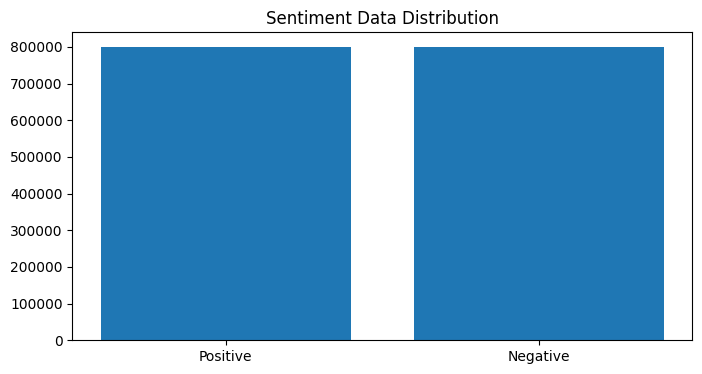

In [8]:
val_count=df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
random_idx_list = random.sample(range(len(df)), 10)
df.iloc[random_idx_list]

,sentiment,text
1098718,Positive,@RobPattinson_ come to Switzerland Rob !!! lot...
1242640,Positive,@Medros *hit* take that I have hit you with my...
1266770,Positive,Conan O'Brien ran thru Wrigley!!! Loved it!
567939,Negative,"@monetpaulette it's a german dumpling soup, so..."
136978,Negative,Not feeling so good Think i am getting sick a...
977117,Positive,mmm... nurse gave me drugs for the bad tooth.....
93018,Negative,What a long day. Annnnd I really need a new job.
1160795,Positive,@gummybearboy I am. Dun worry. Niight.
48510,Negative,is in Tunisia..sat in front of a Sun ULTRA-5 w...
1435606,Positive,Watching a Cheetah Girls marathon w/ daughter ...


In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

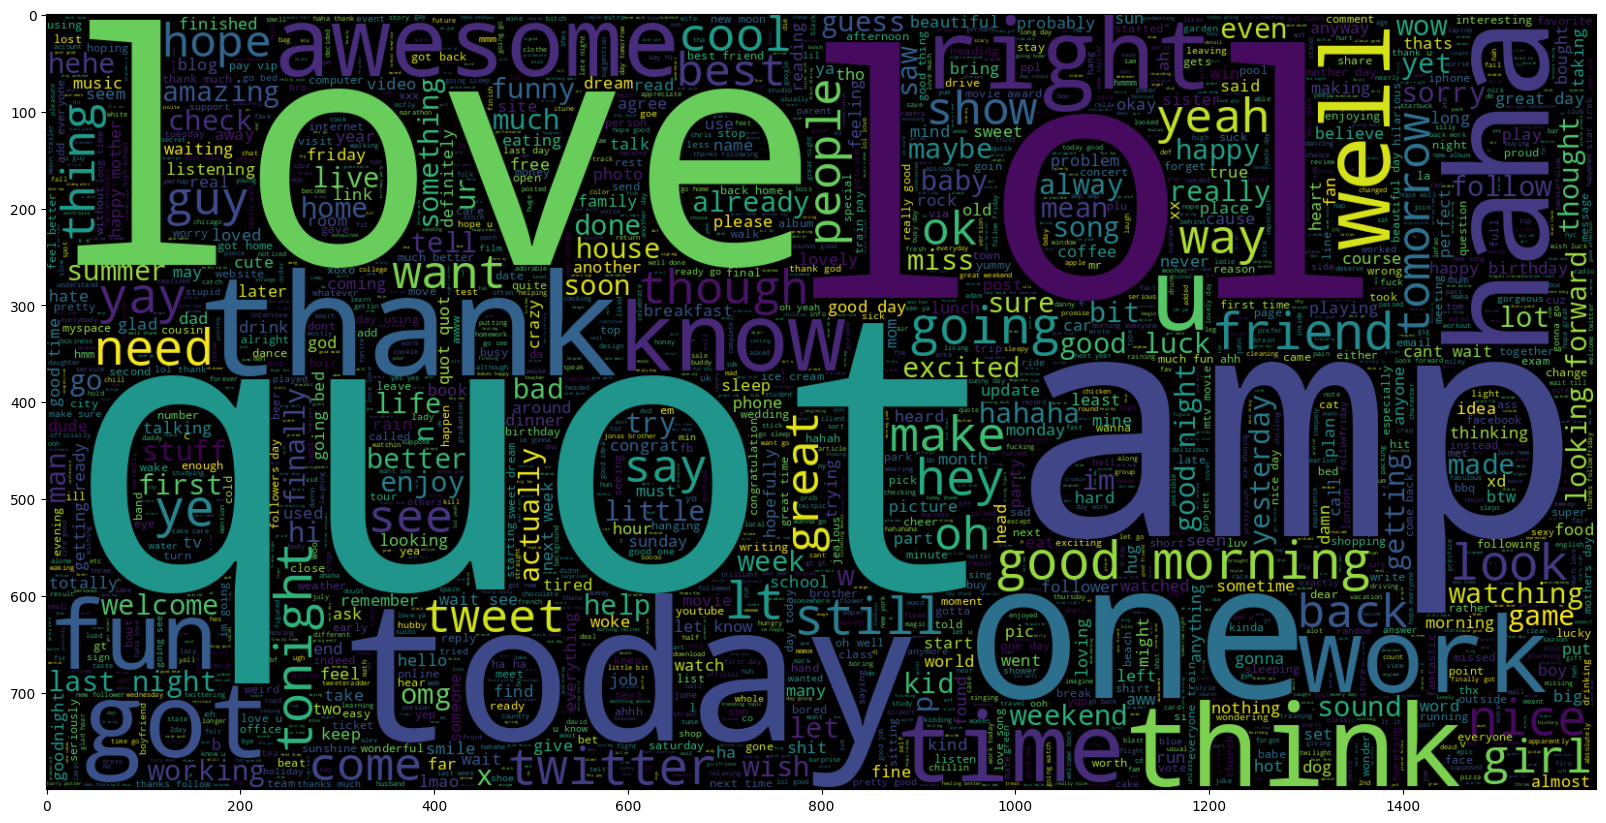

In [13]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000,width=1600,height=800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

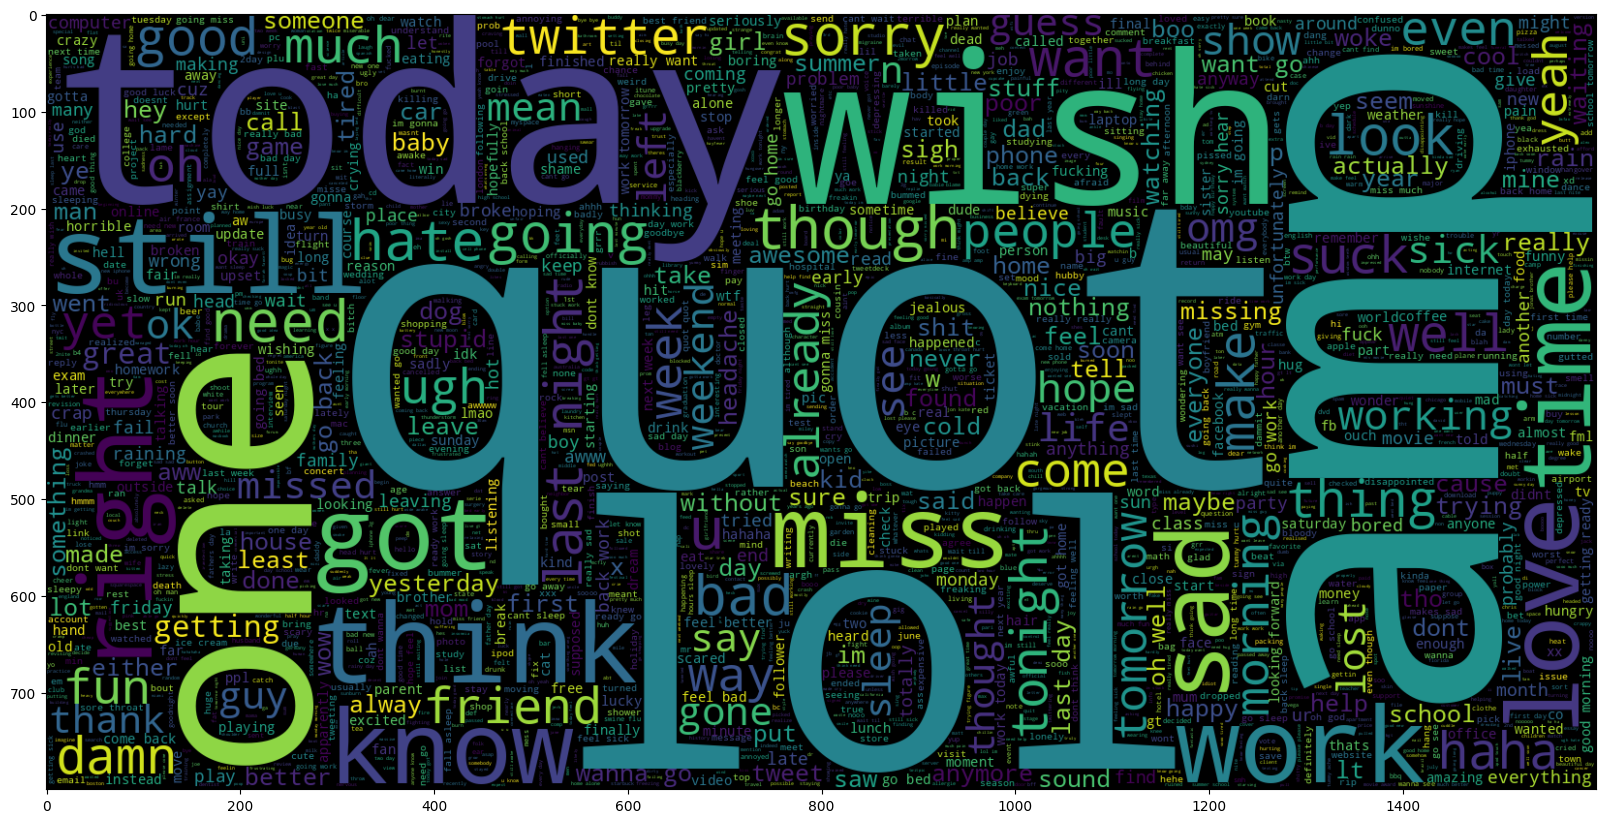

In [14]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment=='Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
train_data,test_data=train_test_split(df,test_size=0.2,random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1279999
Test Data size 320000


In [16]:
train_data.sample(10)

,sentiment,text
222525,Negative,well positive gone fishing pic might interesti...
860382,Positive,looking forward event nyc tomorrow sharpening ...
631317,Negative,crying spilled milk ok maybe eye watering alle...
1597764,Positive,agentsullivan montenegro drtbrennan
913422,Positive,arsenal shirt
1068792,Positive,thanks girlie
1036312,Positive,waiting 4 hubby
1229656,Positive,thanks
175082,Negative,kinda looking forward seeing seann william sco...
217130,Negative,idiot


In [17]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index=tokenizer.word_index
vocab_size=len(tokenizer.word_index) +1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290658


In [18]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = 30)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1279999, 30)
Testing X Shape: (320000, 30)


In [19]:
labels = train_data.sentiment.unique().tolist()
labels

['Positive', 'Negative']

In [20]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


In [21]:
!kaggle datasets download thanakomsn/glove6b300dtxt

Dataset URL: https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt
License(s): DbCL-1.0
 84% 324M/386M [00:00<00:00, 696MB/s]
100% 386M/386M [00:00<00:00, 597MB/s]


In [22]:
!unzip /content/glove6b300dtxt.zip
!rm /content/glove6b300dtxt.zip

Archive:  /content/glove6b300dtxt.zip
  inflating: glove.6B.300d.txt       


In [23]:
embeddings_index = {}

f = open('/content/glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [24]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [25]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          output_dim=300,
                                          weights=[embedding_matrix],
                                          input_length=30,
                                          trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 30, 300)        │    87,197,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 30, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,688,729 (334.51 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 87,197,400 (332.63 MB)

In [28]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [29]:
history = model.fit(x_train, y_train, batch_size=1024, epochs=50,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 248s 188ms/step - accuracy: 0.7157 - loss: 0.5476 - val_accuracy: 0.7634 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 257s 188ms/step - accuracy: 0.7600 - loss: 0.4909 - val_accuracy: 0.7666 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 263s 189ms/step - accuracy: 0.7679 - loss: 0.4794 - val_accuracy: 0.7738 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 232s 186ms/step - accuracy: 0.7726 - loss: 0.4720 - val_accuracy: 0.7775 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 229s 183ms/step - accuracy: 0.7746 - loss: 0.4684 - val_accuracy: 0.7775 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 182ms/step - accuracy: 0.7780 - loss: 0.4635 - val_accuracy: 0.7787 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 264s 184ms

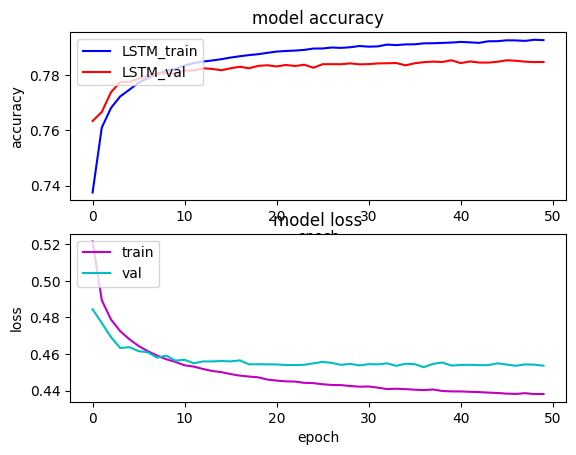

In [30]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [31]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


In [32]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

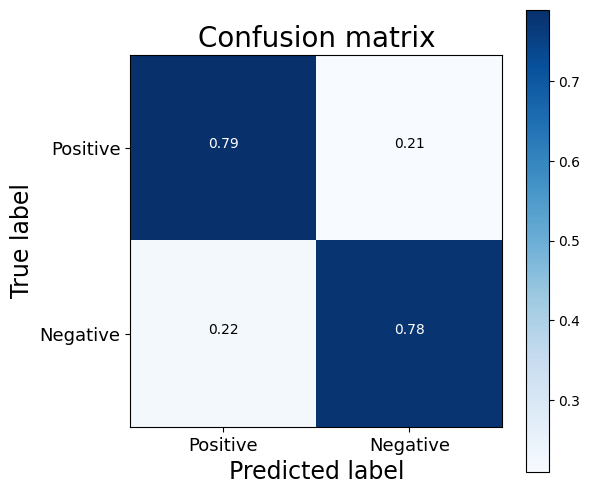

In [33]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [34]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79    160336
    Positive       0.79      0.78      0.78    159664

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

